In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.width', 150)

In [120]:
import matplotlib.pyplot as plt
import seaborn as sn
def print_report(Y_true, Y_pred, output_labels=None, target_names=None, threshold_df=-1.0, threshold_cm=-1.0, remain_symmetric=True, title=None, figsize=(10, 8)):
    if title:
        print(title)
        
    if threshold_df is not None:
        accu = np.average([accuracy_score(true, pred) for true, pred in zip(Y_true, Y_pred)])
        recl = np.average([recall_score(true, pred, average=None, labels=output_labels) for true, pred in zip(Y_true, Y_pred)], axis=0)
        prec = np.average([precision_score(true, pred, average=None, labels=output_labels) for true, pred in zip(Y_true, Y_pred)], axis=0)
        print('Accuracy: %.2f' % (accu * 100) + '%')
        df = pd.DataFrame({
            "Sensitivity": ['%.2f%%' % (x * 100) for x in recl],
            "Precision": ['%.2f%%' % (x * 100) for x in prec]
        })
        if target_names is not None:
            df.index = target_names
        for idx, row in df.iterrows():
            if len(list(filter(lambda x: float(x[:-1]) > threshold_df * 100, row))) == 0:
                df.drop(index=idx, inplace=True)
        print(df)
        print()

    if threshold_cm is not None:
        cm = sum([confusion_matrix(true, pred, labels=output_labels) for true, pred in zip(Y_true, Y_pred)]) / len(Y_pred)

        d_row = []
        for idx, row in enumerate(cm):
            if len(list(filter(lambda x: x > threshold_cm, row))) == 0:
                d_row.append(idx)
        d_col = []
        for idx, col in enumerate(cm.T):
            if len(list(filter(lambda x: x > threshold_cm, col))) == 0:
                d_col.append(idx)

        if remain_symmetric:
            d_both = list(set(d_row).intersection(set(d_col)))
            d_row = d_both
            d_col = d_both
        cm = np.delete(cm, d_row, 0)
        cm = np.delete(cm, d_col, 1)
        plt.figure(figsize=figsize)
        if title:
            plt.title(title)
        if target_names is not None:
            sn.heatmap(cm, annot=True, cbar=False, fmt='.2f', square=True,
                xticklabels=['Predicted ' + name for name in [name for idx, name in enumerate(target_names) if idx not in d_col]], 
                yticklabels=['True ' + name for name in [name for idx, name in enumerate(target_names) if idx not in d_row]])
            plt.setp(plt.xticks()[1], rotation=30, family='monospace')
            plt.setp(plt.yticks()[1], rotation=0, family='monospace')
        else:
            sn.heatmap(cm, annot=True, cbar=False, fmt='.2f', square=True)

In [2]:
# Read file
csv = pd.read_csv('../../data/notification_sequence.csv')

In [3]:
# Manipulate the features
new_csv = {
    'gender': [],
    'age': [],
    'department': [],
    'scenario': [],
    'view-order': [],
    'total': [],
    'social': [],
    'communication': [],
    'entertainment': [],
    'notification': []
}
Y_111111 = []
Y_1122 = []
Y_123 = []
Y_222 = []
Y_24 = []
Y_15 = []

for idx, row in csv.iterrows():
    if row['social_usetime'] == '?':
        continue
    tot = int(row['social_usetime']) + int(row['communication_usetime']) + int(row['entertainment_usetime']) + int(row['news_usetime']) + int(row['system_usetime']) + int(row['notification_usetime'])
    if tot == 0:
        continue
    new_csv['gender'].append(row['gender'])
    new_csv['age'].append(row['age'])
    new_csv['department'].append(row['department'])
    new_csv['scenario'].append(row['scenario'])
    new_csv['view-order'].append(1 if row['view_order_top'] == 1 else (0 if row['view_order_middle'] == 1 else -1))
    new_csv['total'].append(row['total_usetime'])
    new_csv['social'].append(int(row['social_usetime']) / tot)
    new_csv['communication'].append(int(row['communication_usetime']) / tot)
    new_csv['entertainment'].append(int(row['entertainment_usetime']) / tot)
    new_csv['notification'].append(int(row['notification_usetime']) / tot)
    Y_111111.append(row['tol_111111'])
    Y_1122.append(row['tol_1122'])
    Y_123.append(row['tol_123'])
    Y_222.append(row['tol_222'])
    Y_24.append(row['tol_24'])
    Y_15.append(row['tol_15'])

new_csv = pd.get_dummies(pd.DataFrame(new_csv))
X = np.array(new_csv.values)
print('\n'.join([f'{i} {x}' for i, x in enumerate(new_csv.columns)]))

0 age
1 view-order
2 total
3 social
4 communication
5 entertainment
6 notification
7 gender_F
8 gender_M
9 department_bi
10 department_cs
11 department_ed
12 department_ee
13 department_lb
14 department_mg
15 department_oe
16 department_ot
17 department_sc
18 scenario_commuting
19 scenario_resting
20 scenario_wakingup
21 scenario_working


In [131]:
# Model performance
for tol, tol_name in [(Y_111111, '111111'), (Y_1122, '1122'), (Y_123, '123'), (Y_222, '222'), (Y_24, '24'), (Y_15, '15')]:
    accu = []
    for i in range(100):
        X_train, X_test, Y_train, Y_test = train_test_split(X, tol, train_size=0.7)

        _mean = np.mean(X_train, axis=0)
        _std = np.std(X_train, axis=0)
        _scale = np.full(X_train.shape[1], 1.0)
        _scale[-4:] *= 0.25
        _scale[3:6] *= 2.85

        X_train -= _mean
        X_train /= _std
        X_train *= _scale
        X_test -= _mean
        X_test /= _std
        X_test *= _scale

        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, Y_train)
        Y_pred = knn.predict(X_test)
        accu.append(accuracy_score(Y_test, Y_pred))
    print('KNN Tolerance-%s Accuracy=%.3f%%' % (tol_name, np.mean(accu) * 100))

KNN Tolerance-111111 Accuracy=21.042%
KNN Tolerance-1122 Accuracy=27.937%
KNN Tolerance-123 Accuracy=34.692%
KNN Tolerance-222 Accuracy=32.363%
KNN Tolerance-24 Accuracy=51.489%
KNN Tolerance-15 Accuracy=61.979%


In [5]:
# Drop some features to see the influence on accuracy
drop_table = {
    'age': [],
    'view-order': [],
    'total': [],
    'social': [],
    'communication': [],
    'entertainment': [],
    'notification': [],
    'gender': [],
    'department': [],
    'scenario': []
}

for remove in [[0], [1], [2], [3], [4], [5], [6], [7, 8], [9, 10, 11, 12, 13, 14, 15, 16, 17], [18, 19, 20, 21]]:
    print(f'Test - dropping [{", ".join(new_csv.columns[remove])}]')
    drop_name = new_csv.columns[remove[0]].split('_')[0]
    X_adj = np.delete(X, remove, 1)
    for tol, tol_name in [(Y_111111, '111111'), (Y_1122, '1122'), (Y_123, '123'), (Y_222, '222'), (Y_24, '24'), (Y_15, '15')]:
        accu = []
        for i in range(100):
            X_train, X_test, Y_train, Y_test = train_test_split(X_adj, tol, train_size=0.7)

            _mean = np.mean(X_train, axis=0)
            _std = np.std(X_train, axis=0)
            _scale = np.full(X_train.shape[1], 1.0)
            _scale[-4:] *= 0.25
            _scale[3:6] *= 2.85

            X_train -= _mean
            X_train /= _std
            X_train *= _scale
            X_test -= _mean
            X_test /= _std
            X_test *= _scale

            knn = KNeighborsClassifier(n_neighbors=3)
            knn.fit(X_train, Y_train)
            Y_pred = knn.predict(X_test)
            accu.append(accuracy_score(Y_test, Y_pred))
        drop_table[drop_name].append('%.3f%%' % (np.mean(accu) * 100))

drop_table = pd.DataFrame(drop_table, index=['tol_111111', 'tol_1122', 'tol_123', 'tol_222', 'tol_24', 'tol_15'])
# drop_table.to_csv('drop_table.csv')
print('====================================================================================================')
print('===========================================ShowingResults===========================================')
print(drop_table.rename(columns={
    'view-order': 'vw-ord',
    'communication': 'commun',
    'entertainment': 'entert',
    'notification': 'notifi',
    'department': 'depart'
}))

Test - dropping [age]
Test - dropping [view-order]
Test - dropping [total]
Test - dropping [social]
Test - dropping [communication]
Test - dropping [entertainment]
Test - dropping [notification]
Test - dropping [gender_F, gender_M]
Test - dropping [department_bi, department_cs, department_ed, department_ee, department_lb, department_mg, department_oe, department_ot, department_sc]
Test - dropping [scenario_commuting, scenario_resting, scenario_wakingup, scenario_working]
===========================================ShowingResults===========================================
                age   vw-ord    total   social   commun   entert   notifi   gender   depart scenario
tol_111111  19.236%  21.464%  18.890%  20.932%  20.608%  20.042%  20.667%  19.823%  19.772%  19.924%
tol_1122    27.300%  28.502%  25.844%  27.797%  28.114%  27.321%  27.738%  26.371%  26.532%  27.224%
tol_123     34.190%  35.376%  34.025%  35.249%  35.177%  34.806%  34.620%  34.840%  34.004%  34.084%
tol_222     31.342%

Confusion Matrix (tol_15)
Accuracy: 62.87%
  Sensitivity Precision
C      76.67%    68.66%
E      25.00%    25.00%
N      56.94%    60.29%
S      43.48%    50.00%
W      16.67%   100.00%
Y      50.00%   100.00%

Confusion Matrix (tol_15) (Truncated)


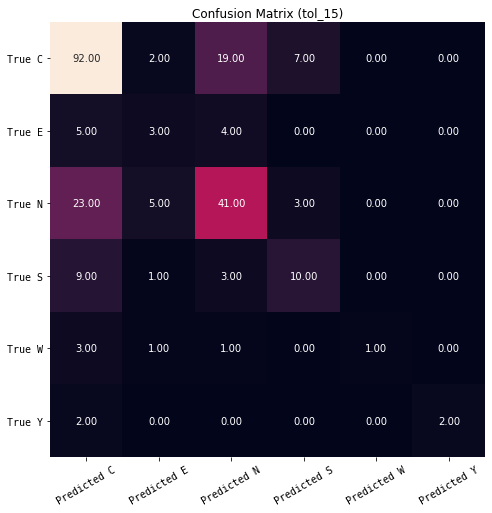

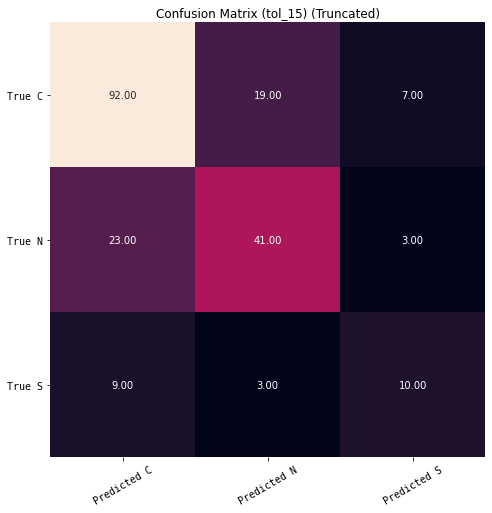

In [112]:
# Scores - tol_15
Y_enc = [l[0].upper() for l in Y_15]
enc = LabelEncoder().fit(Y_enc)
Y_enc = enc.transform(Y_enc)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, train_size=0.7)

_mean = np.mean(X_train, axis=0)
_std = np.std(X_train, axis=0)
_scale = np.full(X_train.shape[1], 1.0)
_scale[-4:] *= 0.25
_scale[3:6] *= 2.85

X_train -= _mean
X_train /= _std
X_train *= _scale
X_test -= _mean
X_test /= _std
X_test *= _scale

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

print_report([Y_test], [Y_pred], enc.transform(enc.classes_), enc.classes_, title='Confusion Matrix (tol_15)')
print_report([Y_test], [Y_pred], enc.transform(enc.classes_), enc.classes_, title='Confusion Matrix (tol_15) (Truncated)', threshold_df=None, threshold_cm=8.0)

_ = """
可以看出在最大宗的三項中明顯出現難以分辨的情況(C, N, S的9格)(見圖二)
"""

Confusion Matrix (tol_123) (Truncated)
Accuracy: 29.11%
       Sensitivity Precision
cesnwy      53.12%    32.08%
cewnsy     100.00%    25.00%
cnsewy      40.54%    25.00%
cnwesy      36.36%    23.53%
csweny      10.53%     9.52%
csyenw     100.00%   100.00%
ncsewy      38.46%    45.45%
ncwesy      13.33%    40.00%
scenwy      41.67%    55.56%
scnewy      16.67%   100.00%
scyenw     100.00%   100.00%
ynwces      50.00%   100.00%



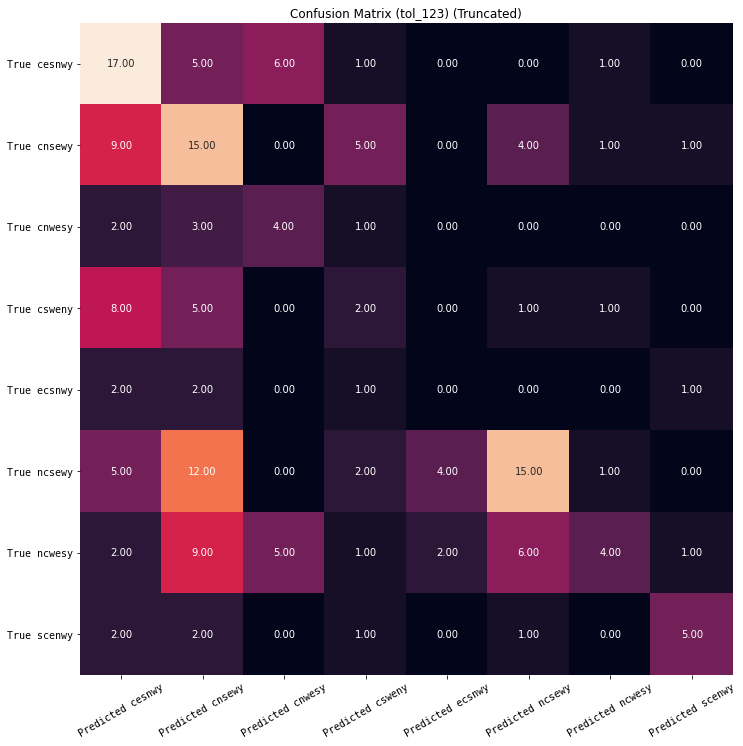

In [127]:
# Scores - tol_123
Y_enc = Y_123
enc = LabelEncoder().fit(Y_enc)
Y_enc = enc.transform(Y_enc)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, train_size=0.7)

_mean = np.mean(X_train, axis=0)
_std = np.std(X_train, axis=0)
_scale = np.full(X_train.shape[1], 1.0)
_scale[-4:] *= 0.25
_scale[3:6] *= 2.85

X_train -= _mean
X_train /= _std
X_train *= _scale
X_test -= _mean
X_test /= _std
X_test *= _scale

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

print_report([Y_test], [Y_pred], enc.transform(enc.classes_), enc.classes_, figsize=(15, 12), title='Confusion Matrix (tol_123) (Truncated)', threshold_df=0.0, threshold_cm=2.0)
_ = """
下圖為truncate過的confusion matrix (只顯示其中含有大於2.0的值之行/列)，可以發現truncate過後剩下的都是大宗通知類型在前的排序 (c, n等)
除此之外還能看到下圖有向左、向下集中的趨勢，說明了模型傾向猜測幾種較為常見的排序
"""

Confusion Matrix (tol_111111) (Truncated)
Accuracy: 21.94%
       Sensitivity Precision
cesnwy     100.00%    25.00%
cesnyw     100.00%    25.00%
cnsewy      60.00%    50.00%
cnswey      42.86%    37.50%
cnswye      25.00%    16.67%
cnwsye      50.00%    50.00%
cnwyse     100.00%    50.00%
csenwy      33.33%    18.18%
csenyw      66.67%    28.57%
csewny      11.11%     4.35%
csewyn      50.00%    37.50%
cseynw     100.00%    50.00%
csnewy      16.67%    10.00%
csnwey      33.33%    18.18%
csnwye      42.86%   100.00%
cswnye      50.00%    16.67%
cwnsey      33.33%    33.33%
cwseny      33.33%   100.00%
ecswny      25.00%   100.00%
ecswyn      33.33%    50.00%
ncsewy       9.09%    50.00%
ncswey      26.67%    66.67%
ncswye      60.00%    60.00%
ncwsey      16.67%    20.00%
ncwsye      50.00%    28.57%
nwcsey      16.67%    20.00%
scewyn      50.00%    40.00%
scnewy      66.67%    66.67%
ynwesc     100.00%   100.00%



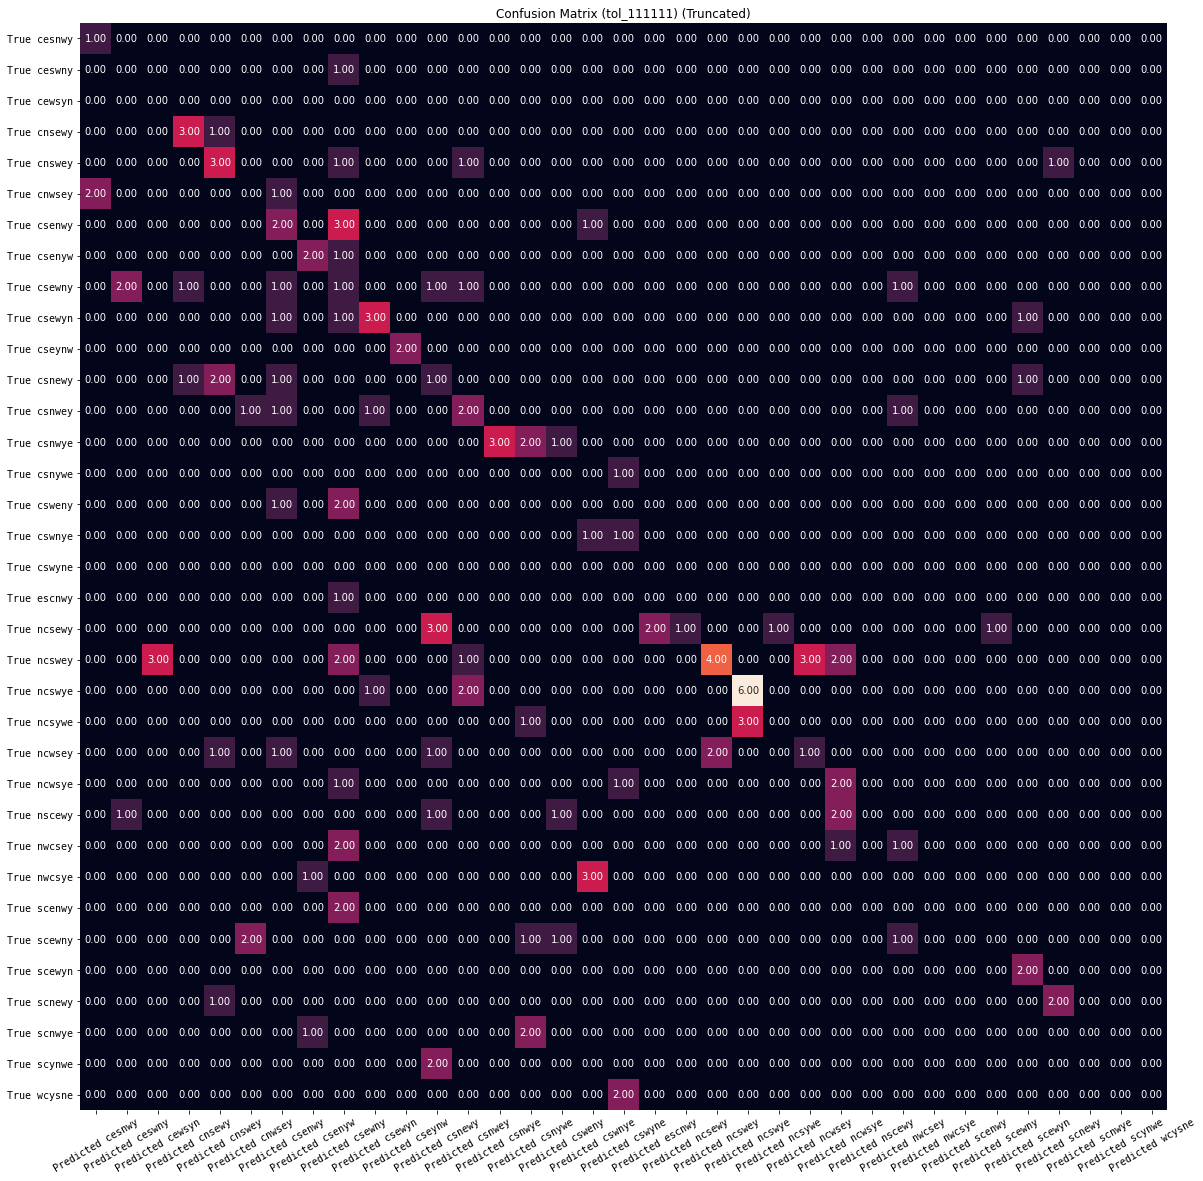

In [134]:
# Scores - tol_111111
Y_enc = Y_111111
enc = LabelEncoder().fit(Y_enc)
Y_enc = enc.transform(Y_enc)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_enc, train_size=0.7)

_mean = np.mean(X_train, axis=0)
_std = np.std(X_train, axis=0)
_scale = np.full(X_train.shape[1], 1.0)
_scale[-4:] *= 0.25
_scale[3:6] *= 2.85

X_train -= _mean
X_train /= _std
X_train *= _scale
X_test -= _mean
X_test /= _std
X_test *= _scale

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

print_report([Y_test], [Y_pred], enc.transform(enc.classes_), enc.classes_, figsize=(25, 20), title='Confusion Matrix (tol_111111) (Truncated)', threshold_df=0.0, threshold_cm=1.0)
_ = """
下圖為truncate過的confusion matrix (只顯示其中含有大於1.0的值之行/列)，可以發現confusion matrix中仍然有不少的色塊落在左下角區域，顯示模型仍然傾向猜測某幾個出現率相對高的label
沒有truncate的版本見附檔tol_123_cm.png/tol_111111_cm.png
"""